In [4]:
from tensorflow.keras.layers import Input, Add, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.models import Model
from datasets import load_dataset
import numpy as np
import os
from multiprocessing import Pool
from IPython.display import clear_output
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import random,os,glob
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mp
import random
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam


In [14]:
train_path = 'dataset (1)/train/'
val_path = 'dataset (1)/val/'
test_path = 'dataset (1)/test/'

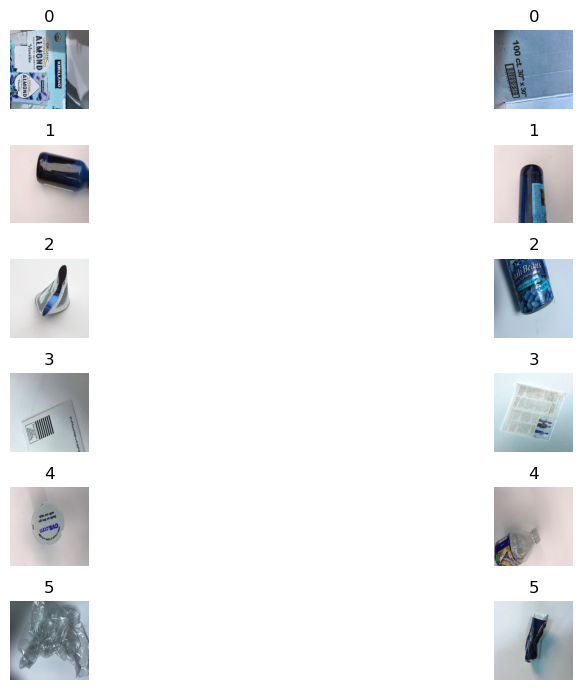

In [15]:



images = []
for garbage_class in os.listdir(train_path):
    class_path = os.path.join(train_path, garbage_class)
    image_files = os.listdir(class_path)
    images.extend([os.path.join(class_path, f) for f in random.sample(image_files, 2)])

# Display the images
fig, axes = plt.subplots(6, 2, figsize=(14,7))
for i, image_path in enumerate(images):
    image = mp.imread(image_path)
    ax = axes[i//2, i%2]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(os.path.basename(os.path.dirname(image_path)))

plt.tight_layout()
plt.show()

In [21]:
image_size = (299, 299)
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    batch_size=300,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=300,
    class_mode='categorical',
    shuffle=False
)

y_train = train_generator.classes
y_val = val_generator.classes
y_test = test_generator.classes


Found 4043 images belonging to 6 classes.
Found 505 images belonging to 6 classes.
Found 506 images belonging to 6 classes.


In [24]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Input

img_input = (299, 299, 3)  

xception_base = Xception(weights="imagenet", include_top=False, input_shape=img_input)

for layer in xception_base.layers[:-3]:
    layer.trainable = False

model_xception = Sequential()

model_xception.add(xception_base)

model_xception.add(MaxPooling2D(pool_size=3, strides=2, padding='same'))
model_xception.add(Flatten())

model_xception.add(Dense(512, activation='relu'))
model_xception.add(Dropout(0.5))

model_xception.add(Dense(256, activation='relu'))
model_xception.add(Dropout(0.5))

model_xception.add(Dense(128, activation='relu'))
model_xception.add(Dropout(0.3))

model_xception.add(Dense(64, activation='relu'))

model_xception.add(Dense(6, activation='softmax'))  

model_xception.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 3,163,648 (12.07 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

In [25]:
optimizer = Adam(learning_rate=0.0001)
model_xception.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_xception.fit(
    train_generator,
    epochs=100,  
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2212 - loss: 2.2619

I0000 00:00:1734031059.567659     114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_maximum_fusion_3', 4 bytes spill stores, 4 bytes spill loads



64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.2248 - loss: 2.2443 - val_accuracy: 0.6277 - val_loss: 1.2690
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4198 - loss: 1.4546 - val_accuracy: 0.6990 - val_loss: 0.9076
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5690 - loss: 1.1475 - val_accuracy: 0.7604 - val_loss: 0.7142
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6392 - loss: 0.9626 - val_accuracy: 0.7980 - val_loss: 0.5941
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7006 - loss: 0.8269 - val_accuracy: 0.8158 - val_loss: 0.5469
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7509 - loss: 0.7057 - val_accuracy: 0.8158 - val_loss: 0.4568
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7697 - loss: 0.6745 - val_accuracy: 0.8376 - val_loss: 0.4206
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8094 - loss: 0.5798 - val_accuracy: 0.8495 - val_loss: 0.

In [28]:
model_xception.save("model.h5")

In [29]:
model_xception.evaluate(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9376 - loss: 0.1719 


[0.20135411620140076, 0.9328063130378723]

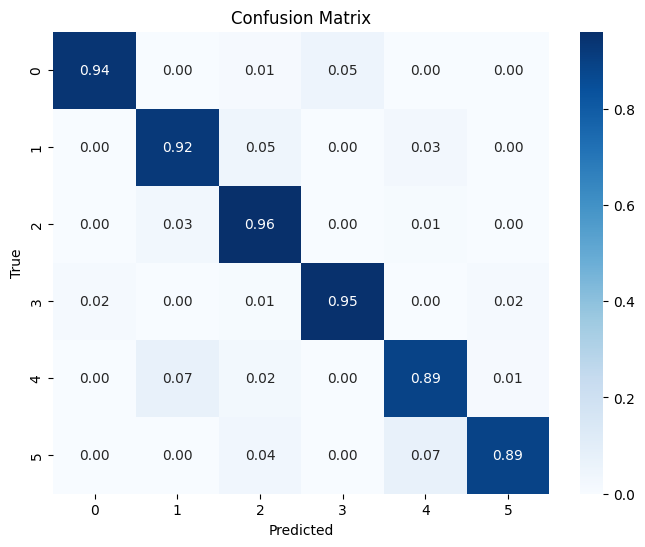

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model("model (1).h5")


In [22]:

y_pred_probs = model1.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1) 
y_true = test_generator.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 92s 29s/step


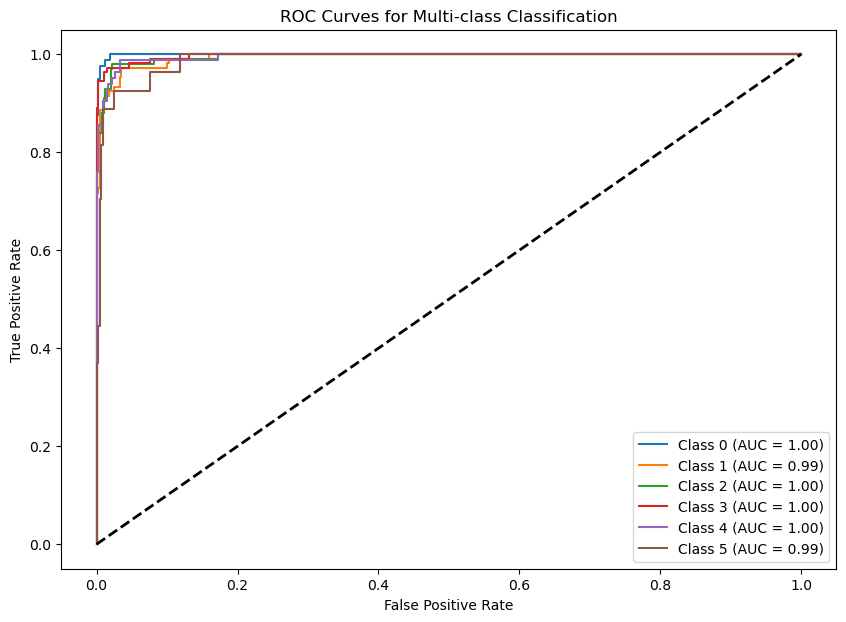

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import numpy as np

n_classes = len(set(y_true))  
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np



n_classes = len(set(y_true))  

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
auc = roc_auc_score(y_true_bin, y_pred_probs, average='weighted', multi_class='ovr')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Precision: 0.9379
Recall: 0.9368
F1-Score: 0.9370
AUC: 0.9958
